<a href="https://colab.research.google.com/github/imiled/DL_Tools_For_Finance/blob/master/CNN_main__teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neural Networks

This notebook introduces the concept of Convolutional Neural Networks (CNN or ConvNets)(LeCun, 1989), one of the most important neural networks architecture that have been succesfully applied to solve many grid-like data based problems, such the ones related with image processing (2D grid of pixels) --image recognition, edge detection, etc-- or the analysis of time series (1D grid).

CNNs were inspired by how the visual cortex of human brain works when recognizing objects.
Our vision is based on multiple cortex levels, each one recognizing more and
more structured information. First, we see single pixels; then we can recognize
simple geometric forms. And then... more and more sophisticated elements such as objects and so on.
In the same way, CNNs learn meaningful representations of the input data in a compositional and hierarchical way -- any abstract concept is based on simpler concepts!

To do that, CNNs make use of three main mechanisms:
- **Sparse interactions**. CNNs, which replace at least one of the fully connected layers of a neural network by the convolution operation, have less capacity than a fully connected network. As we need to store fewer parameters, the training is more efficient 

- **Parameter sharing**. This means that rather than learning a separate set of parameters for every location, we learn only one set.

- **Equivariant representation**. As a consequence of parameter sharing, CNNs have the ability to detect the same feature independently from the location where it is placed in the input image

In this class, we will dive deep in all these concepts, covering the following topics:

- Understanding convolution operations. 

- Learning about the building blocks of CNN architectures

- Implementing deep convolutional neural networks in keras


## Basics

ConvNets are simply neural networks that use the convolutional operation in place of general matrix multiplication in at least one of their layers. As we will see in the next section, convolutions aggregate information from a neighborhood and act as a pattern-matching filters, activating more strongly in response to specific local patterns.


#### Understanding the convolution operation

Let us start developing intuition for the convolution operation in one dimension. Given two functions $x(t)$ and $\omega(t)$, the (discrete) convolution operation is defined as
$$ s( t ) = (x\ast\omega)(t) = \sum_a x ( a ) \omega ( t - a )$$

An equivalent form of this operation given the commutativity of the convolution operation is as follows:
$$ s( t ) = \sum_a x ( t - a ) \omega ( a )$$

Furthermore, the negative sign (flipping) can be replaced to get cross-correlation given as follows:
$$ s ( t ) = \sum_a x ( t + a ) \omega ( a )$$
*In the machine learning community, both operators (convolutions and cross-correlations) are used interchangeably.*

From the above equations, convolutions can be seen as a weighted sum of $x(t)$, with weights controlled by the $\omega(t)$ function -- weights depends on the distance between any $t$ and the output point. That is, the output point summarizes information about the value of $x(t)$ across the function’s full domain, but it does so according to how far away these points are from it. 

![2 gaussian convolutioning](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/13_CNN_convgaus.gif?raw=true)

*The green curve shows the convolution of the blue and red curves as a function of t, the position indicated by the vertical green line. The gray region indicates the product g(tau)f(t-tau) as a function of t, so its area as a function of t is precisely the convolution.*

Formally, a convolution is an operation on two real functions. The first argument $x$ is referred as the input, and the second argument $\omega$ as the kernel. The output is referred as the feature map. In two dimensions, we have the following expression::

$$ S(i, j) = (X\ast W)(i, j) = \sum_m \sum_n X(m,n) W (i-m, j-n)$$

![How convolution 2d works](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/13_CNN_convolution.gif?raw=true)

*Note that convolution is equivalent to converting both the input and the kernel to the frequency domain using a Fourier transform, performing point-wise multiplication of the two signals, and converting back to the time domain using an inverseFourier transform.*

Ex: Define a function that implements the convolutional operator.

In [ ]:
import numpy as np

def convolve2d(input_, kernel):
    input_shape = input_.shape
    kernel_shape = kernel.shape
    output_shape = (input_shape[0] - kernel_shape[0],
                    input_shape[1] - kernel_shape[1])
    output = np.zeros(output_shape)            
    for x in range(output_shape[0]):     
        for y in range(output_shape[1]):
            i = input_[x:x+kernel_shape[0], y:y+kernel_shape[1]]
            output[x, y] = np.sum(i * kernel)        
    return output

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io, color
from skimage import exposure

Import an image:

In [ ]:
def load_image(path):
    # Load the image
    img = io.imread(path)    
    # Convert the image to grayscale (1 channel)
    img = color.rgb2gray(img)      
    return img

Run the convolution. What happens with the figure? Try with other kernels (`np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])`, for example)

In [ ]:
import warnings

def run(image_path, kernel=np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])):
    img = load_image(image_path)
    edges = convolve2d(img, kernel)
    # Adjust the contrast of the filtered image by applying Histogram Equalization
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        edges_equalized = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)
        plt.imshow(edges_equalized, cmap=plt.cm.gray)    
        plt.axis('off')
        plt.show()

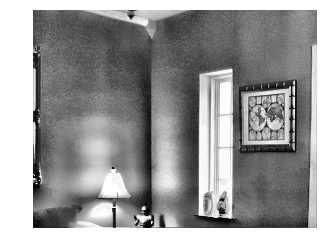

In [ ]:
run('../imgs/13_CNN_conv_imag_ex.jpg', np.array([[1,1,1],[1,1,1],[1,1,1]])/9.0) #Blur filter

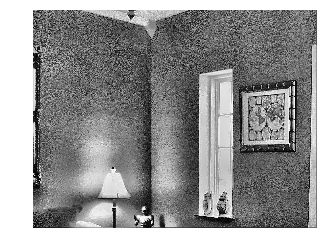

In [ ]:
run('../imgs/13_CNN_conv_imag_ex.jpg', np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])) #Sharpen filter

#### Variants of the basic Convolution Function

#### Striding

Sometimes we could be interested in downsampling the output of the convolution function. In such a case, the computational cost associated with the convolutional operation would be reduced at the expense of not extracting the feature as finely as possible.

One way of accomplishing this is by using a stride $s$. The stride means that we are going to sample only every $s$ pixels in each direction in the output:

$$ S(i, j) = (X\ast W)(i, j) = \sum_m \sum_n X_{(i-1)s + m, (j-1)s + n} W_{m, n}$$

![How stride works](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/13_CNN_striding.gif?raw=true) 


For instance, a stride of 2 means picking slides 2 pixels apart, skipping every other slide in the process, downsizing by roughly a factor of 2.



Ex. Change the convolution function to include the stride parameter.

In [ ]:
def convolve2d_stride(input_, kernel, stride):
    input_shape = input_.shape
    kernel_shape = kernel.shape
    output_shape = np.array([input_shape[0] - kernel_shape[0],
                    input_shape[1] - kernel_shape[1]]) // stride 
    output_shape = output_shape + 1 if stride > 1 else output_shape
    output = np.zeros(output_shape)  
    for i, x in enumerate(range(0, input_shape[0] - kernel_shape[0], stride)):     
        for j, y in enumerate(range(0, input_shape[1] - kernel_shape[1], stride)):
            m = input_[x:x + kernel_shape[0], 
                       y:y + kernel_shape[1]]
            output[i, j] = np.sum(m * kernel)        
    return output

In [ ]:
def run_stride(image_path, kernel=np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]), stride=2):
    img = load_image(image_path)
    edges = convolve2d_stride(img, kernel, stride)
    # Adjust the contrast of the filtered image by applying Histogram Equalization
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        edges_equalized = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)
        plt.imshow(edges_equalized, cmap=plt.cm.gray)    # plot the edges_clipped
        plt.axis('off')
        plt.show()

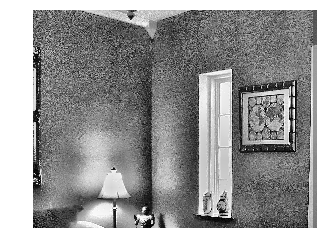

In [ ]:
run_stride('../imgs/13_CNN_conv_imag_ex.jpg', np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]), 4)

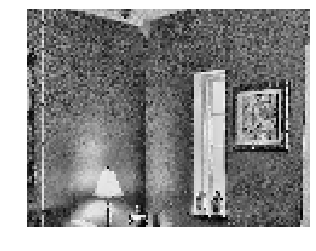

In [ ]:
run_stride('../imgs/13_CNN_conv_imag_ex.jpg', np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]), 10)

#### Padding

Have a look at the following convolution animation:

![Convolution result](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/13_CNN_conv_.gif?raw=true)

What happens with the dimension of the feature matrix?
Yes, she is reduced from a 5×5 dimension to a 3×3 one. This isn’t ideal, as often we’d like the size of the output to equal the input.
 
![Padding in convolutions](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/13_CNN_padding.gif?raw=true) 
 
 
Padding allows us to solve this problem easily. In essence, this technique pad the edges with extra, “fake” pixels (usually of value 0). 
In other words, padding defines how the border of a sample is handled. A padded convolution will keep the spatial output dimensions equal to the input, whereas unpadded convolutions will crop away some of the borders if the kernel is larger than 1.

Ex. Add padding funcionality to the prevoius convolve2d_stride function:

In [ ]:
def convolve2d_stride_padding(input_, kernel, stride, padding):
    input_shape = input_.shape
    kernel_shape = kernel.shape
    output_shape = (np.array([input_shape[0] - kernel_shape[0],
                    input_shape[1] - kernel_shape[1]]) + 2 * padding)// stride 
    output_shape = output_shape + 1 if stride > 1 or padding > 1 else output_shape
    
    zero_padding_x = np.zeros((padding, input_shape[1]))
    input_padding = np.vstack((zero_padding_x, input_, zero_padding_x))
    ipad_shape = input_padding.shape
    zero_padding_y = np.zeros((ipad_shape[0], padding))
    input_padding = np.hstack((zero_padding_y, input_padding, zero_padding_y))
    ipad_shape = input_padding.shape
    
    output = np.zeros(output_shape)  
    for i, x in enumerate(range(0, ipad_shape[0] - kernel_shape[0], stride)):     
        for j, y in enumerate(range(0, ipad_shape[1] - kernel_shape[1], stride)):
            m = input_padding[x:x + kernel_shape[0], 
                       y:y + kernel_shape[1]]
            output[i, j] = np.sum(m * kernel)        
    return output

In [ ]:
def run_stride_padding(image_path, kernel=np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]), 
                       stride=2, padding=2):
    img = load_image(image_path)
    edges = convolve2d_stride_padding(img, kernel, stride, padding)
    # Adjust the contrast of the filtered image by applying Histogram Equalization
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        edges_equalized = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)
        plt.imshow(edges_equalized, cmap=plt.cm.gray)    
        plt.axis('off')
        plt.show()

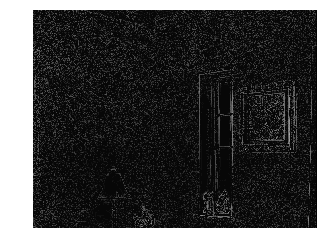

In [ ]:
run_stride_padding('../imgs/13_CNN_conv_imag_ex.jpg', kernel=np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]), 
                       stride=1, padding=1)

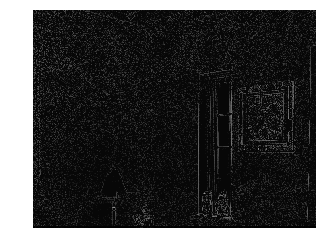

In [ ]:
run_stride_padding('../imgs/13_CNN_conv_imag_ex.jpg', kernel=np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]), 
                       stride=1, padding=2)

### Building Blocks of CNNs

After the input layer, Convnets mainly consist of stacks of convolution and max-pooling layers. This two elements are responsible for extracting features from the input and ususally repeats as a block several times to increase the depth of a CNN.

#### Convolutional layer

As it said before, convolutional layers are the key feature layers that makes CNNs different from other ordinary neural networks, and are characterized for applying a convolution operation to the input, passing the result (after activated) to the next layer. In keras, we call a convolutional layer as follows:

```
keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
```

__Note__: In Keras there are two options for padding: same or valid. Same means we pad with the number on the edge and valid means no padding

#### Pooling

Pooling operation replaces the output of the net at a certain location with a summary statistic of the nearby outputs. 
As a consequence, pooling helps to make the representation approximately invariant to small translations of the input. 

Mainly there are two types of pooling:

- **max-pooling**: returns the maximum output within a rectangular neighborhood. In keras we invoke max-pooling using the next command:
```
keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
```

- **average-pooling**: computes the average of a neighborhood. Keras implements average pooling in the function:
```
keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
```

![Pooling layer](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/13_CNN_pooling_layer_.jpeg?raw=true)

### Implementing CNNs in Keras

With all the previous ideas in mind, let's practice and play around with CNNs to solve some common images' problems. Let's start with MNIST.

#### MNIST

As all of you probably know, this data set consists of handwritten digits (60,000 training examples and 10,000 test
examples). The task at hand is to predict the digit given the image, so this is a multiclassifcation problem with ten classes.

Ex. Import and load the data using `keras.datasets.mnist.load_data()`.

Using TensorFlow backend.


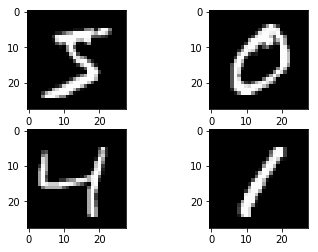

In [ ]:
#MNIST
from keras.datasets import mnist
from keras.utils import np_utils

# Image Size
img_rows, img_cols = 28, 28

# Prepare dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()



Do a one-hot encoding and normalize the images:

In [ ]:
# Prepare dataset
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
nb_classes = 10
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Implement a CNN following these main points:
1.	The network consists of two convolution (RELU) + a max pooling layer + two layer fully connected
2.	The size of the kernel is 3 × 3.
3.	The pooling operation is done over sections of dimensionality 2 × 2.
4.  Set dropout parameter to 0.25
5.	The output layer is softmax and the loss function is categorical entropy, 
7.	The model is fit using adadelta 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Filter
nb_filters = 32
# Pooling
pool_size = (2, 2)
# Kernel
kernel_size = (3, 3)


# CNN
model = Sequential()
model.add(Conv2D(nb_filters, kernel_size, padding='valid', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

Train and evaluate the model:

In [ ]:
# Compilation
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
# Training
batch_size = 128
nb_epoch = 1
model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# Evaluation
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test Metrics:",(model.metrics_names, score))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 61s 1ms/step - loss: 0.2897 - acc: 0.9098 - val_loss: 0.0602 - val_acc: 0.9804
Test Metrics: (['loss', 'acc'], [0.06015423580580391, 0.9804])


Plot a random sample of 10 test images, their predicted labels and ground truth



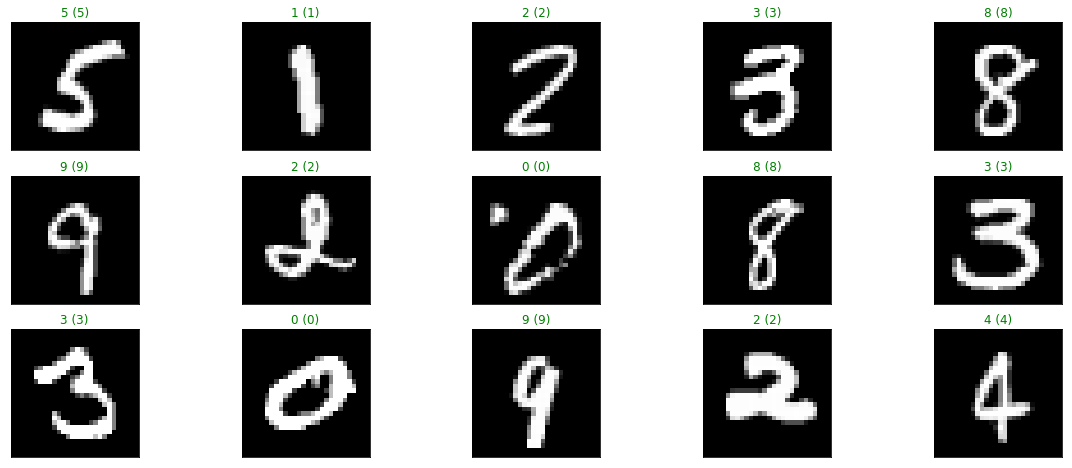

In [ ]:
x_hat = model.predict(X_test)

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]), cmap=plt.get_cmap('gray'))
    predict_index = np.argmax(x_hat[index])
    true_index = np.argmax(Y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(true_index, predict_index),
                                  color=("green" if predict_index == true_index else "red"))

Ex. Visualize the weights of the first 15 filters of the first layer, and save them in a list called 'filters':

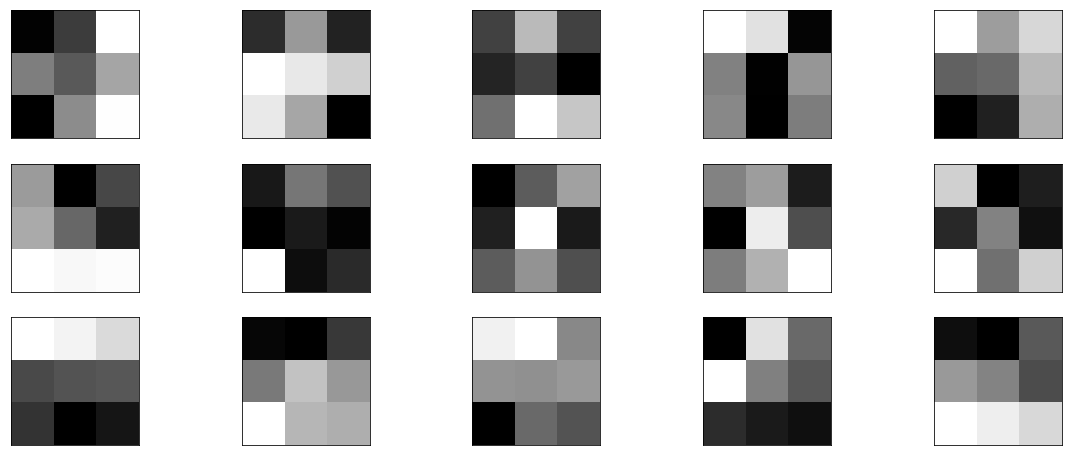

In [ ]:
# Visualize weights
figure = plt.figure(figsize=(20, 8))
filters = []
for i, index in enumerate(range(15)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    top_layer = model.layers[0]
    plt.imshow(top_layer.get_weights()[0][:, :, :, i].squeeze(), cmap='gray')
    filters.append(top_layer.get_weights()[0][:, :, :, i].squeeze())

Ex: Apply the filters to a test image using convolve2d function (defined at the beginning of the notebook). What do you observe?

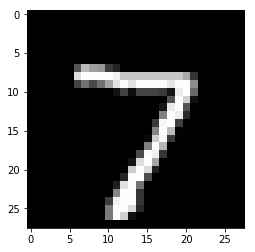

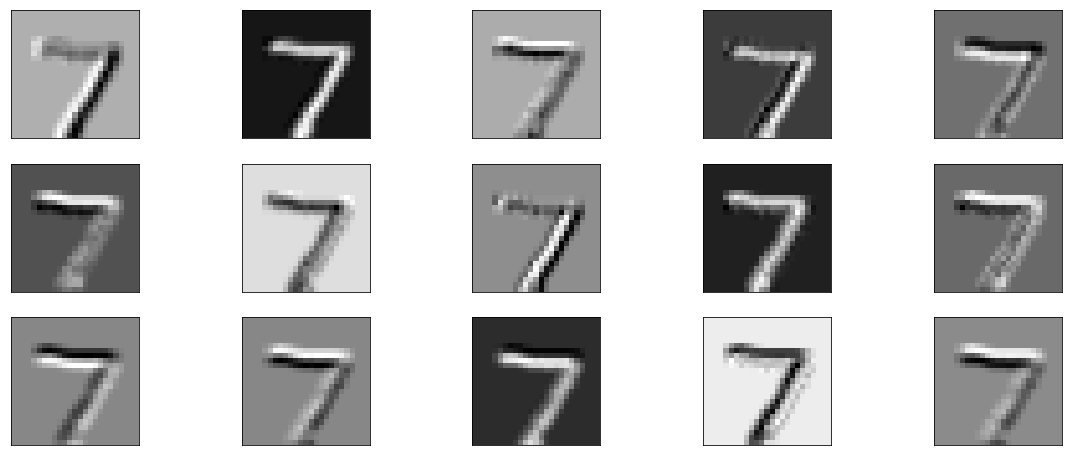

In [ ]:
index = 0
img = np.squeeze(X_test[index])
plt.imshow(img, cmap=plt.get_cmap('gray'))
figure = plt.figure(figsize=(20, 8))
for i, f in enumerate(filters):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(convolve2d(img, f), cmap=plt.get_cmap('gray'))


As you can see, each filter has learned to activate optimally for different features of the image. In particular they usually act as edge detectors and color filters. We will continue this discussion later on with the VGG16 architecture.


Ex. Break CAPCTHA system with the help of CNNs (see corresponding notebook).


#### CIFAR-10

On the other hand, CIFAR-10 dataset contains 60,000 color images of 32 x 32 pixels in 3 channels divided
into 10 classes. Each class contains 6,000 images. The training set contains 50,000 images,
while the test sets provides 10,000 images

Load CIFAR data set using `keras.datasets.cifar10.load_data()`:

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


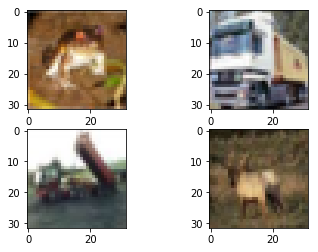

In [ ]:
from keras.datasets import cifar10

#load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

Do a one-hot encoding and normalize the images:

In [ ]:
NB_CLASSES = 10

#Convert to categorical
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)

#float and normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

Implement the model according to the following rules:
1. Conv layer with 32 filters, each of which with a 3 x 3 size. 
2. The output dimension is the same one of the input shape, so it will be 32 x 32 and activation is ReLU,
3.  After that we have a max-pooling operation with pool size 2 x 2 and a dropout at 25%
4. Add a dense network with 512 units and ReLU activation followed by a dropout at 50% and by a softmax layer with 10 classes as output, one for each category

In [ ]:
from keras.optimizers import RMSprop

#CIFAR_10 is a set of 60k images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

#constant
BATCH_SIZE = 128
NB_EPOCH = 20
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIM = RMSprop()

#Network
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
__________

Train and run the model. What is the accuracy level?

In [ ]:
# train
model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
model.fit(X_train, Y_train,  batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
validation_split=VALIDATION_SPLIT, verbose=VERBOSE)
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 55s 1ms/step - loss: 1.7654 - acc: 0.3757 - val_loss: 1.4471 - val_acc: 0.4915
Epoch 2/20
40000/40000 [==============================] - 54s 1ms/step - loss: 1.3940 - acc: 0.5054 - val_loss: 1.3026 - val_acc: 0.5410
Epoch 3/20
40000/40000 [==============================] - 55s 1ms/step - loss: 1.2573 - acc: 0.5541 - val_loss: 1.1820 - val_acc: 0.5861
Epoch 4/20
40000/40000 [==============================] - 58s 1ms/step - loss: 1.1693 - acc: 0.5883 - val_loss: 1.1221 - val_acc: 0.6104
Epoch 5/20
40000/40000 [==============================] - 56s 1ms/step - loss: 1.1009 - acc: 0.6143 - val_loss: 1.0907 - val_acc: 0.6170
Epoch 6/20
40000/40000 [==============================] - 56s 1ms/step - loss: 1.0403 - acc: 0.6350 - val_loss: 1.1853 - val_acc: 0.5934
Epoch 7/20
40000/40000 [==============================] - 56s 1ms/step - loss: 0.9872 - acc: 0.6555 - val_loss: 1.0290 - val_acc

Ex. Visualize the feature maps learned by the conv layer

In [ ]:
from keras import backend as K

def layer_to_visualize(layer):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(20,8))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i], cmap=plt.get_cmap('gray'))

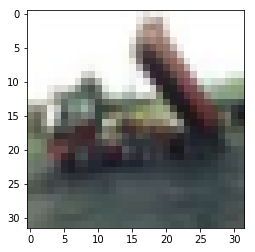

Shape of conv: (32, 32, 32)


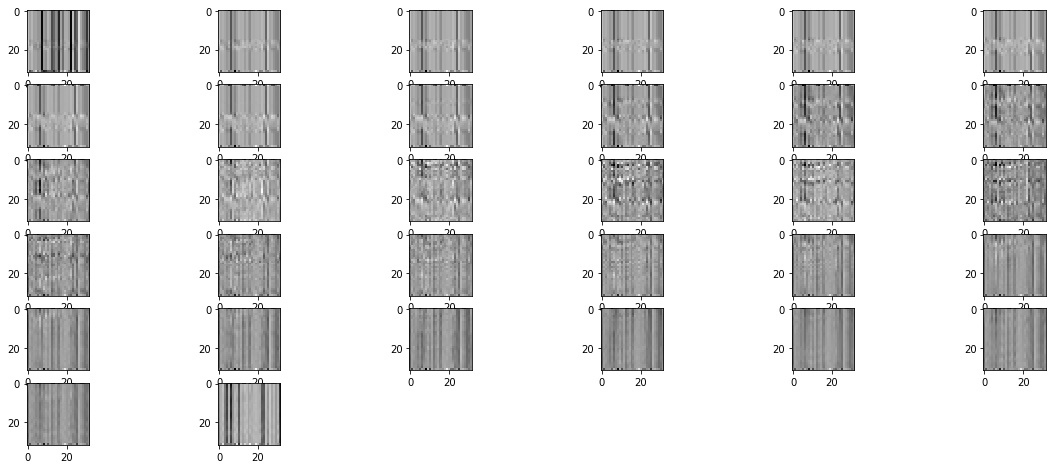

In [ ]:
index = 2
plt.imshow(X_train[index], cmap=plt.get_cmap('gray'))
plt.show()
img_to_visualize = X_train[index]
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)

layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_to_visualize(layer_dict['conv2d_3'])

### Going Deep

In this section we will discuss two classical, commonly used architectures for convolutional networks: VGG16 and LENET5. As you'll see, these deep CNN architectures apply successively convolutional layers to the input, periodically downsampling the spatial dimensions while increasing the number of feature maps. In essence, we can view these deep arquitectures as rich feature extractors and as a schemes that allows for more efficient learning.

Find more detail about deep CNN architectures in the following links:

#### Deep CNNs Architectures

1. [VGG](https://arxiv.org/pdf/1409.1556.pdf)
2. [LENET5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)
3. [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
4. [GoogleNet/Inceptionv1](https://arxiv.org/pdf/1409.4842.pdf)
5. [Inceptionv3](https://arxiv.org/pdf/1512.00567.pdf)
6. [ResNet](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)


### Use case: Recognizing cats with a VGG-16 net

VGG-16 consists of 16 convolutional layers and has a total of about 138 million parameters. All conv layers are 3x3 filters with stride 1 and always use the SAME padding. Max polling layers are 2 by 2 with a strid of 2. 

Have a look at her architecture:


![VGG16 architecture](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/13_CNN_vgg16.png?raw=true)
![VGG16 weigth configuration](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/13_CNN_vgg_conf.png?raw=true)
*VGGNet achieved excellent results on the ILSVRC-2014 (ImageNet competition) getting the top-5 accuracy (92.3 %) on ImageNet*

Ex.- Derive the total number of parameters (take D configuration):

Hints:
- For the first convolutional layer, the network has to learn 64 filters with size 3x3 along the input depth (3). Plus, each one of the 64 filters has a bias, so the total number of parameters is 64*3*3*3 + 64 = 1792. You can apply the same logic for other convolutional layers.

- The depth of a layer’s output will be the number of its convolutional filters. The padding is chosen as 1 pixel so the spatial resolution is preserved through the convolutional layers. Thus, the spatial resolution will only change at the pooling layers. So, the output of the first convolutional layer will be 224 x 224 x 64.

- The pooling layer does not learn anything, so we have 0 learnable parameters in it. To calculate the output shape of the pooling layer, we have to consider the size of the window and the stride. Since the window is 2 x 2 and the stride is 2, the layer is outputting a pixel for every 2 x 2 pixels and jumping by 2 pixels to do the next calculation (no overlap occurs), so the spatial resolution is divided by 2 in each pooling layer. The depth remains the same.

- To calculate the number of parameters in the fully-connected layers, we have to multiply the number of units in the previous layer by the number of units in the current layer. By following the logic presented in the previous paragraphs, you can see that the number of units in the last convolutional layer will be 7x7x512. So, the total number of parameters in the first fully-connected layer will be 7x7x512x4096 + 4096 = 102764544 for configuration D.

Ex: Implement VGG16 architecture:

In [ ]:
from keras.layers import ZeroPadding2D
from keras.optimizers import SGD

#define a VGG16 network
def VGG_16():

    K.set_image_dim_ordering('th')
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3,224,224)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000))
    model.add(Activation('softmax'))
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

Check your implementation with the one provided by keras:

In [ ]:
model = VGG_16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
activation_8 (Activation)    (None, 64, 224, 224)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
activation_9 (Activation)    (None, 64, 224, 224)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 112, 112)      0         
__________

In [ ]:
from keras.applications import vgg16
model = vgg16.VGG16(weights='imagenet', include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 224, 224)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 224, 224)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 112, 112)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 112, 112)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 112, 112)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 56, 56)       0         
__________

Let's use the pre-trained VGG-16 model include in keras to train and predict images. Use SGD optimizer and categorical crossentropy loss.
Load https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/egyptian_cat.jpg?raw=true using wget and cv2.imread and resize to the dimension (224, 224) with cv2.resize. Is the predicted label equal to 285 (=egyptian cat)?

In [ ]:
import cv2

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

#resize into VGG16 trained images' format
im = cv2.resize(cv2.imread('../imgs/13_CNN_egyptian_cat.jpeg'), (224, 224))
im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
im = np.expand_dims(im, axis=0)

#predict
out = model.predict(im)     
print('Predicted class is %d' %(np.argmax(out)))
#this should print 285 for Egyptian cat


Predicted class is 285


Ex: Visualize the filters of the block1_conv1 - block5_conv1 layers via gradient ascent in input space.

In [ ]:
from keras.preprocessing.image import save_img
import time

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
#layer_name = 'block5_conv1'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


block1_conv1


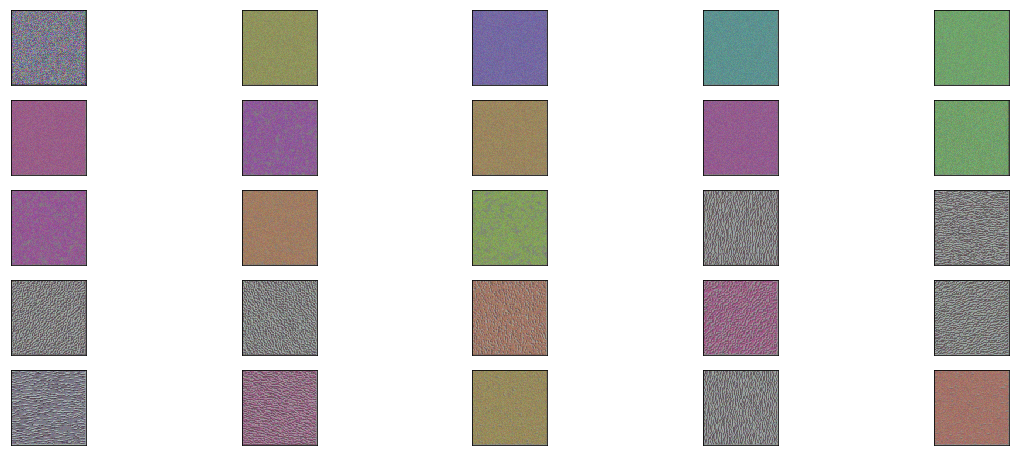

block2_conv1


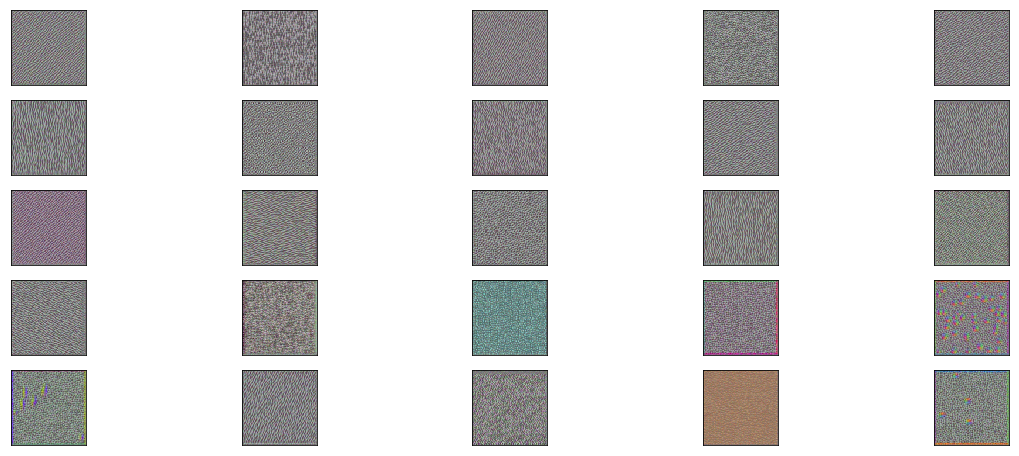

block3_conv1


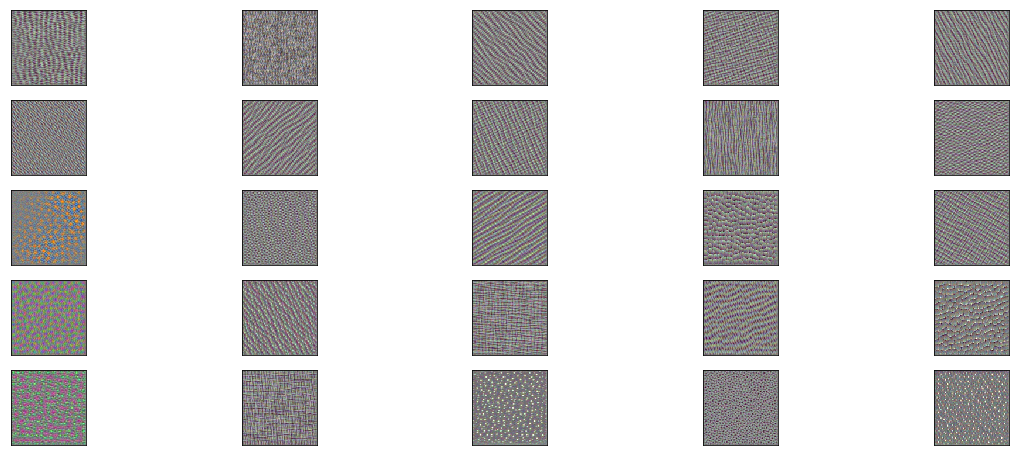

block4_conv1


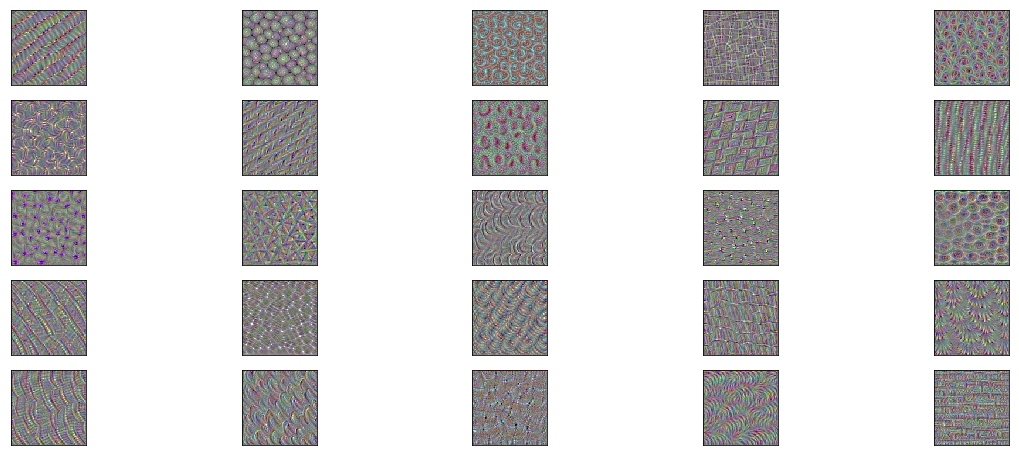

block5_conv1


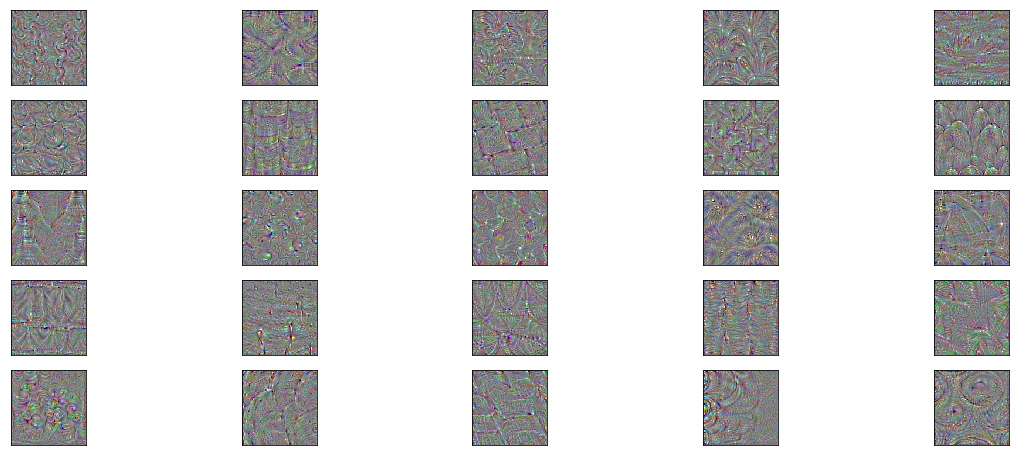

In [ ]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']:

    kept_filters = []
    for filter_index in range(64):
        # we only scan through the first 200 filters,
        # but there are actually 512 of them
        #print('Processing filter %d' % filter_index)
        start_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # step size for gradient ascent
        step = 1.

        # we start from a gray image with some random noise
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random((1, 3, img_width, img_height))
        else:
            input_img_data = np.random.random((1, img_width, img_height, 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # we run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

            #print('Current loss value:', loss_value)
            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break

        # decode the resulting input image
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))
        end_time = time.time()
        #print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

    # we will stich the best 64 filters on a 8 x 8 grid.
    n = 5

    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 64 filters.
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:n * n]

    figure = plt.figure(figsize=(20, 8))
    for i in range(n):
        for j in range(n):
            img, loss = kept_filters[i * n + j]
            ax = figure.add_subplot(n, n, i * n + j + 1, xticks=[], yticks=[])
            plt.imshow(img)

    print(layer_name)
    plt.show()

Last figures displayed the patterns each filter maximally responds to or is very active.
Note that:

- The first layer filters (block1_conv2 and block2_conv2) mostly detect colors, edges and simple shapes.

- As we go deeper into the network, the filters build on top of each other, and learn to encode more complex patterns. Can you recognize any of them?


### Smile Dataset & LENET5

In this section we will implement the LeNet-5 architecture, a pioneering 7-level convolutional network developed in 1998 by LeCun et al to identify handwritten digits for zip code recognition in the postal service. 


![LeNet architecture](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/13_CNN_LENET.png?raw=true)

Lenet-5 consists of 3 convolutional layers (C1, C3 and C5), 2 sub-sampling (pooling) layers (S2 and S4), and 1 fully connected layer (F6), that are followed by the output layer. Convolutional layers use 5 by 5 convolutions with stride 1. Sub-sampling layers are 2 by 2 average pooling layers. Tanh sigmoid activations are used throughout the network.

Implement LeNet-5 architecture:

In [ ]:
def lenet5(width, height, depth, classes):
    K.set_image_dim_ordering('th')
    model = Sequential()
    inputShape = (height, width, depth)
    
    if K.image_data_format() == 'channels_first':
        inputShape = (depth, height, width)
        
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))
        
    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    return model
        

Let's test our implementation using the **Smiles dataset**.

The SMILES dataset consists of images of faces that are either smiling or not smiling. In total, there are 13,165 grayscale images in the dataset, with each image having a size of 64 × 64 pixels


Download the data from https://github.com/hromi/SMILEsmileD/archive/master.zip and run the next cell to see the number of positive and negative examples:

In [ ]:
import os

smile_path =  '../data/SMILEsmileD-master/'

def list_all_files(directory, extensions=None):
    for root, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            base, ext = os.path.splitext(filename)
            joined = os.path.join(root, filename)
            if extensions is None or ext.lower() in extensions:
                yield joined

negative_paths = list(list_all_files(os.path.join(smile_path,'SMILEs/negatives/negatives7/'), ['.jpg']))
print('loaded', len(negative_paths), 'negative examples')
positive_paths = list(list_all_files(os.path.join(smile_path, 'SMILEs/positives/positives7/'), ['.jpg']))
print('loaded', len(positive_paths), 'positive examples')
examples = [(path, 0) for path in negative_paths] + [(path, 1) for path in positive_paths]

loaded 9475 negative examples
loaded 3690 positive examples


Let's show some negative and positive images with the help of the following functions:

In [ ]:
from skimage.measure import block_reduce
from skimage.io import imread
from io import BytesIO
import PIL.Image
import IPython.display

def show_array(a, fmt='png', filename=None):
    a = np.uint8(np.clip(a, 0, 255))
    image_data = BytesIO()
    PIL.Image.fromarray(a).save(image_data, fmt)
    if filename is None:
        IPython.display.display(IPython.display.Image(data=image_data.getvalue()))
    else:
        with open(filename, 'w') as f:
            image_data.seek(0)
            shutil.copyfileobj(image_data, f)

def find_rectangle(n, max_ratio=2):
    sides = []
    square = int(math.sqrt(n))
    for w in range(square, max_ratio * square):
        h = n / w
        used = w * h
        leftover = n - used
        sides.append((leftover, (w, h)))
    return sorted(sides)[0][1]

# should work for 1d and 2d images, assumes images are square but can be overriden
def make_mosaic(images, n=None, nx=None, ny=None, w=None, h=None):
    if n is None and nx is None and ny is None:
        nx, ny = find_rectangle(len(images))
    else:
        nx = n if nx is None else nx
        ny = n if ny is None else ny
    images = np.array(images)
    if images.ndim == 2:
        side = int(np.sqrt(len(images[0])))
        h = side if h is None else h
        w = side if w is None else w
        images = images.reshape(-1, h, w)
    else:
        h = images.shape[1]
        w = images.shape[2]
    image_gen = iter(images)
    mosaic = np.empty((h*ny, w*nx))
    for i in range(ny):
        ia = (i)*h
        ib = (i+1)*h
        for j in range(nx):
            ja = j*w
            jb = (j+1)*w
            mosaic[ia:ib, ja:jb] = next(image_gen)
    return mosaic

def examples_to_dataset(examples, block_size=2):
    X = []
    y = []
    for path, label in examples:
        img = imread(path, as_gray=True)
        img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
        img = img.reshape((32*32))
        X.append(img)
        if(label==0):
            y.append((1,0))
        else:
            y.append((0,1))
    return np.asarray(X), np.asarray(y)

X, Y = examples_to_dataset(examples)
X = np.asarray(X,dtype=np.float32)/ 255.
Y = np.asarray(Y,dtype=np.int32)
print(X.dtype, X.min(), X.max(), X.shape)

float32 0.0 1.0 (13165, 1024)


Negative images:

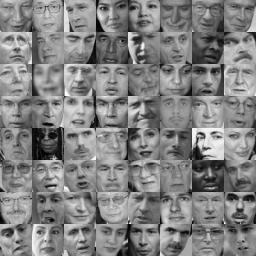

In [ ]:
#show Negative images
show_array(255 * make_mosaic(X[:len(negative_paths)], 8), fmt='jpeg') # negative at the beginning


Positive example:

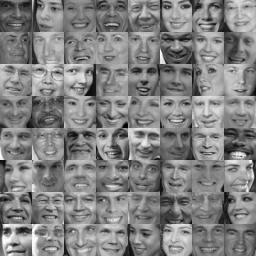

In [ ]:
#show Positive images
show_array(255 * make_mosaic(X[-len(positive_paths):], 8), fmt='jpeg') # positive at the end

Construct data and labels lists looping over the input images:

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array
from imutils import paths
import argparse
import imutils

# loop over the input images
data = []
labels = []
for imagePath in sorted(list(paths.list_images(smile_path))):
  
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = imutils.resize(image, width=28)
    image = img_to_array(image)
    data.append(image)
    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-3]
    label = "smiling" if label == "positives" else "not_smiling"
    labels.append(label)
 

Now that our data and labels are constructed, we can scale the raw pixel intensities to the range [0, 1] and then apply one-hot encoding to the labels:

In [ ]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
# convert the labels from integers to vectors
le = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(le.transform(labels), 2)
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

Now that we’ve computed our class weights, we can move on to partitioning our data into training and testing splits, using 80% of the data for training and 20% for testing:

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
labels, test_size=0.20, stratify=labels, random_state=42)

Finally, we are ready to train LeNet:

In [ ]:
# initialize the model
print("[INFO] compiling model...")
model = lenet5(width=28, height=28, depth=1, classes=2)
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              class_weight=classWeight, batch_size=64, epochs=15, verbose=1)

[INFO] compiling model...
[INFO] training network...
Train on 10532 samples, validate on 2633 samples
Epoch 1/15
10532/10532 [==============================] - 51s 5ms/step - loss: 0.4223 - acc: 0.8026 - val_loss: 0.2984 - val_acc: 0.8731
Epoch 2/15
10532/10532 [==============================] - 43s 4ms/step - loss: 0.2864 - acc: 0.8835 - val_loss: 0.2840 - val_acc: 0.8834
Epoch 3/15
10532/10532 [==============================] - 37s 4ms/step - loss: 0.2497 - acc: 0.8996 - val_loss: 0.3218 - val_acc: 0.8618
Epoch 4/15
10532/10532 [==============================] - 37s 4ms/step - loss: 0.2363 - acc: 0.9073 - val_loss: 0.2483 - val_acc: 0.9028
Epoch 5/15
10532/10532 [==============================] - 37s 4ms/step - loss: 0.2202 - acc: 0.9169 - val_loss: 0.2444 - val_acc: 0.9066
Epoch 6/15
10532/10532 [==============================] - 45s 4ms/step - loss: 0.2097 - acc: 0.9190 - val_loss: 0.2448 - val_acc: 0.9013
Epoch 7/15
10532/10532 [==============================] - 38s 4ms/step - los

Evaluate the network:

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1), 
                            predictions.argmax(axis=1), target_names=le.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

 not_smiling       0.95      0.93      0.94      1895
     smiling       0.83      0.86      0.85       738

   micro avg       0.91      0.91      0.91      2633
   macro avg       0.89      0.90      0.89      2633
weighted avg       0.91      0.91      0.91      2633



Plot the learning curve using the code:

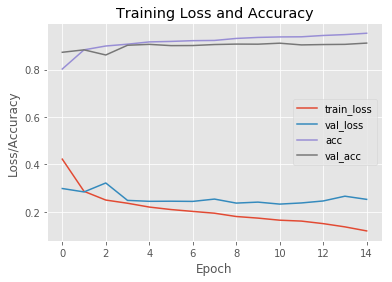

In [ ]:
# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,15), H.history['loss'], label='train_loss')
plt.plot(np.arange(0,15), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0,15), H.history['acc'], label='acc')
plt.plot(np.arange(0,15), H.history['val_acc'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

After 15 epochs we can see that our network is obtaining 93% classification accuracy

Ex. Fingerprint_Denoising_and_Inpainting.ipynb

## References

https://github.com/DataScienceUB/DeepLearningfromScratch2018

Deep Learning for Computer Vision with Python.- Adrian Rosebrock

Deep Learning with keras.- Antonio Gulli, Sujit Pal

Deep Learning with Python.- Francois Chollet

http://colah.github.io/posts/2014-07-Understanding-Convolutions/

https://arxiv.org/abs/1603.07285

https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

https://github.com/keras-team/keras/blob/master/examples/conv_filter_visualization.py

